In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from tqdm import tqdm
import tensorflow as tf

import os


In [2]:
DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data')).replace('\\', '/') + '/'
ANNO_COARSE_PATH = DATA_PATH + 'anno_coarse'
IMG = DATA_PATH + 'img'

ATTR_CLOTH_LIST_FILE = ANNO_COARSE_PATH + '/list_attr_cloth.txt'
ATTR_IMG_LIST_FILE = ANNO_COARSE_PATH + '/list_attr_img.txt'
ATTR_TYPES = {'1':"Estampado",'2':"Tejido",'3':"Forma",'4':"Partes",'5':"Estilo"}

TRAIN_FILE = ANNO_COARSE_PATH + '/train_attr.txt'
TEST_FILE = ANNO_COARSE_PATH + '/test_attr.txt'
VAL_FILE  = ANNO_COARSE_PATH + '/val_attr.txt'

NUM_CLASSES = 1000

En primer lugar cargamos los datos y construimos una serie de estructuras de datos auxiliares para facilitar el análisis:

In [3]:
# Lectura de la lista de atributos
def read_attr_cloth_list():
    column_to_attr_name = {}
    column_to_attr_type = {}
    attr_type_to_columns = {}
    
    with open(ATTR_CLOTH_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ignorar cabecera
        column = 0
        for line in fp: 
            fields = line.split()
            attr = " ".join(fields[:-1])
            attr_type = fields[-1]
            column_to_attr_name[column] = attr
            column_to_attr_type[column] = attr_type
            if attr_type in attr_type_to_columns:
                attr_type_to_columns[attr_type].append(column)
            else:
                attr_type_to_columns[attr_type] = [column]
            column += 1
    return column_to_attr_name, attr_type_to_columns, column_to_attr_type

# Lectura de atributos asociados a una imagen
def read_attr_img_list():
    attr_dict = []
    with open(ATTR_IMG_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de lineas
        fp.readline() # Ignorar cabecera
        for line in fp:
            row = [int(i) for i in line.split()[1:]]
            attr_dict.append(row)
    return pd.DataFrame.from_records(attr_dict)


In [4]:
column_to_attr_name, attr_type_to_columns, column_to_attr_type = read_attr_cloth_list()           
attr_img_list = read_attr_img_list()    
attributes = list(column_to_attr_name.values())

Comprobamos el mínimo y máximo de atributos asociados a una imagen. Vemos que, a diferencia de la versión reducida del conjunto de datos, el número de atributos no es el mismo en todas las imágenes. 

Vemos que existe alrededor de 13000 imágenes no asociadas a ningún atributo, y una única imagen está asociada al valor máximo obtenido (21). 

In [5]:
# Análisis del número mínimo y máximo de atributos que puede tener una imagen
num_attr_per_img = (attr_img_list == 1).astype(int).sum(axis=1)
print('Número mínimo de atributos: {}'.format(min(num_attr_per_img)))
print('Número máximo de atributos: {}'.format(max(num_attr_per_img)))

Número mínimo de atributos: 0
Número máximo de atributos: 21


In [6]:
num_attr_per_img[num_attr_per_img == 21]

178507    21
dtype: int64

In [7]:

num_attr_per_img[num_attr_per_img == 0]

10        0
41        0
51        0
62        0
73        0
         ..
288862    0
288948    0
288959    0
289131    0
289132    0
Length: 12969, dtype: int64

Comprobamos como se distribuye el número de atributos de las imágenes, y vemos que el 75% de las imágenes están asociadas a 4 atributos o menos. 

Text(0.5, 1.0, 'Num. atributos por imagen')

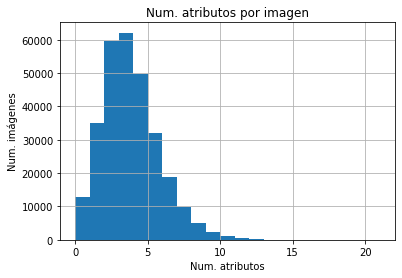

In [8]:
h = num_attr_per_img.hist(bins=21)
h.set_xlabel("Num. atributos")
h.set_ylabel("Num. imágenes")
h.set_title("Num. atributos por imagen")

In [9]:
num_attr_per_img.describe()

count    289222.000000
mean          3.322742
std           1.956819
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          21.000000
dtype: float64

Teniendo en cuenta las tres particiones, comprobamos que frecuencia de aparición tienen el atributo minoritario y el atributo mayoritario.

In [10]:
# Análisis del número mínimo y máximo de atributos que puede tener una imagen
num_img_per_attr = (attr_img_list == 1).astype(int).sum(axis=0)
print('Frecuencia del atributo minoritario: {}'.format(min(num_img_per_attr)))
print('Frecuencia del atributo mayoritario: {}'.format(max(num_img_per_attr)))

Frecuencia del atributo minoritario: 51
Frecuencia del atributo mayoritario: 37367


Comprobamos como se distribuye el número de imágenes en las que aparecen los atributos. El 75% de los atributos está presente en 767 imágenes o menos. El atributo mayoritario está presente en 37367 imágenes. 

Text(0.5, 1.0, 'Num. imágenes en los que aparece un atributo')

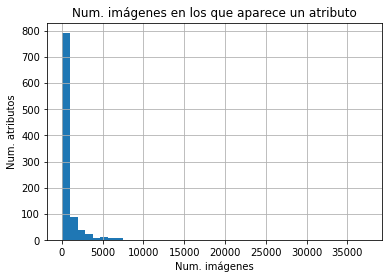

In [11]:
h = num_img_per_attr.hist(bins=40)
h.set_xlabel("Num. imágenes")
h.set_ylabel("Num. atributos")
h.set_title("Num. imágenes en los que aparece un atributo")

In [12]:
num_img_per_attr.describe()

count     1000.000000
mean       961.010000
std       2341.581377
min         51.000000
25%        107.000000
50%        258.000000
75%        767.250000
max      37367.000000
dtype: float64

Vamos a comprobar cuales son estos atributos mayoritarios y minoritarios. 

In [13]:
data = {'count':list(num_img_per_attr), 'i':list(column_to_attr_name.keys()) }
df = pd.DataFrame(data, index=list(column_to_attr_name.values()))
df["type"] = df.apply(lambda row: column_to_attr_type[row['i']], axis = 1) 

df = df.sort_values(by=['count'], ascending=False).drop(['i', 'type'], axis=1)

In [14]:
print('Atributos con mayor frecuencia de aparición')
print(df.head(10))

Atributos con mayor frecuencia de aparición
         count
print    37367
floral   24188
lace     20434
knit     18498
sleeve   17828
maxi     15990
shirt    14920
denim    13178
striped  11771
chiffon  11735


In [15]:
print('Atributos con menor frecuencia de aparición')
print(df.tail(10))

Atributos con menor frecuencia de aparición
                  count
ornate paisley       52
high-rise skinny     52
boxy lace            52
defyant              52
print smock          52
deep-v               51
floral textured      51
topstitched          51
raw-cut              51
floral flutter       51


Comprobamos también la distribución de los distintos atributos dentro de los tipos de atributo. 

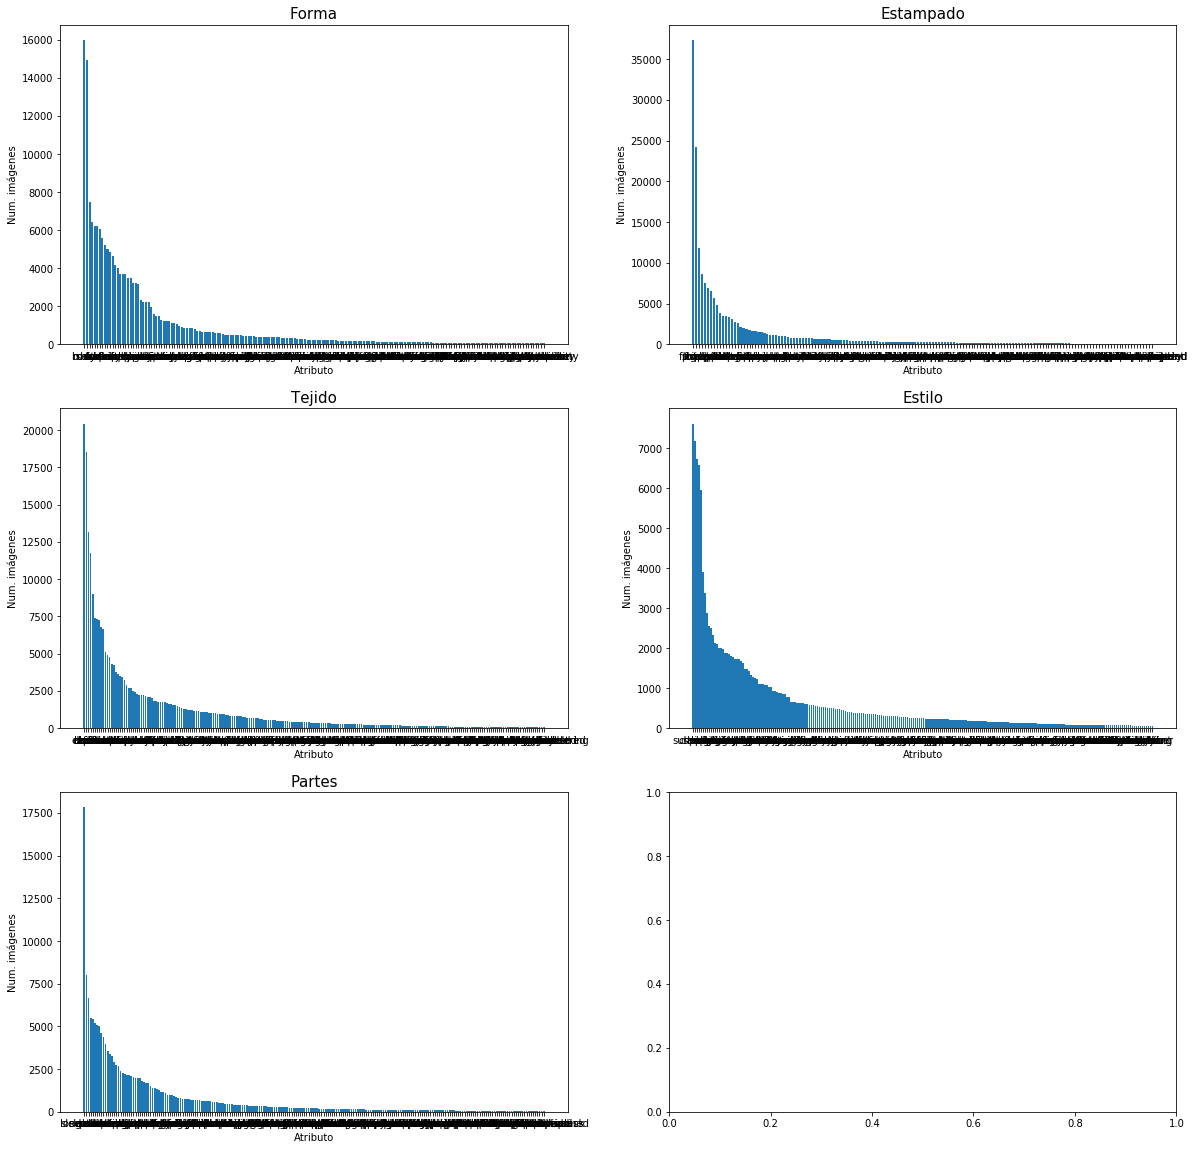

In [16]:
# Análisis de frecuencias dentro de cada tipo de atributo
num_occ_per_attr = (attr_img_list == 1).astype(int).sum(axis=0)
num_occ_per_attr.loc[1]
count = 0
figs = []
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

for attr_type, columns in attr_type_to_columns.items():
    labels = [column_to_attr_name[c] for c in columns]
    counts = [num_occ_per_attr.loc[c] for c in columns]
    
    r = count // 2
    c = count % 2
    
    df = pd.DataFrame(counts, index=labels, columns=["count"])
    df = df.sort_values(by=['count'], ascending=False)
    
    axs[r, c].set_title(ATTR_TYPES[attr_type], fontsize=15)
    axs[r, c].set(xlabel='Atributo', ylabel='Num. imágenes')
    axs[r, c].bar(df.index.values,df['count'])
    count += 1
#plt.show()    
plt.savefig('foo.png')

# Data imbalance

De forma análoga a la versión reducida del conjunto de datos, se va a crear varias versiones alterativas de la partición de entrenamiento para tratar de reducir el impacto del *data imbalance*. En primer lugar, definimos el código necesario para la manipulación de los ficheros de datos. Este código, salvo pequeños detalles, es idéntico al empleado en el *notebook* de la versión reducida del conjunto de datos por lo que se omite su descripción detallada. 

In [17]:
def build_partition_distribution_table():

    names = []
    names.append('filename')
    names.extend([str(i) for i in range(0,NUM_CLASSES)])
    
     # Carga de las anotaciones reales de la partición de entrenamiento
    partition_attribute_filepath = ANNO_COARSE_PATH + "/train_attr.txt"
    y_true_train = pd.read_csv(partition_attribute_filepath, sep = ' ', names = names, index_col=False)
    y_true_train = y_true_train.drop(columns=['filename'])
    
    # Columna de tipo de atributo
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columnas de frecuencia real
    frequency_train = y_true_train.sum().tolist()
    
    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia train' : frequency_train}
    df =  pd.DataFrame(data=d)
    
    # Eliminamos atributos no presentes en la partición
    df = df[df['Frecuencia train'] != 0]

    return df
    

In [18]:
ATTR_IMG_LIST_FILE = ANNO_COARSE_PATH + '/list_attr_img.txt'
PARTITION_FILE = ANNO_COARSE_PATH + '/list_eval_partition.txt'

In [19]:
def read_partition_files():
    data = {}
    data['train'] = []
    data['test'] = []
    data['val'] = []
    with open(PARTITION_FILE) as fp:
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ingorar numero de etiquetas
        for line in fp:
            fields = line.split()
            
            img_path = fields[0]           
            partition = fields[1]
            data[partition].append(img_path)
    return data

In [20]:
partitions = read_partition_files()

In [21]:
def split():
    with open(ATTR_IMG_LIST_FILE) as fp, open(TRAIN_FILE, 'w', newline='') as train_file,open(VAL_FILE, 'w', newline='') as val_file, open(TEST_FILE, 'w', newline='') as test_file:
          
        train_wr = csv.writer(train_file, delimiter=' ')
        test_wr = csv.writer(test_file, delimiter=' ')
        val_wr = csv.writer(val_file, delimiter=' ')

        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ingorar numero de etiquetas
        for line in tqdm(fp):
            
            fields = ['0' if f=='-1' else f for f in line.split()]
            img_path = fields[0]
            
            fields[0] = fields[0].replace('img/', '').replace('/','')
            
            if img_path in partitions['train']:
                train_wr.writerow(fields)
            elif img_path in partitions['val']:
                val_wr.writerow(fields)
            elif img_path in partitions['test']:
                test_wr.writerow(fields)
            else:
                print(img_path)


In [22]:
# Decomentar para generar un fichero por partición de datos. 
# Estos ficheros son necesarios para la ejecución del notebook con la construcción de modelos basados en este conjunto de datos
#split()

In [23]:
def show_frequencies(df):
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columnas de frecuencia real
    df = df.drop(columns=['filename'])
    frequency_train = df.sum().tolist()

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia train' : frequency_train}
    return pd.DataFrame(data=d)

In [24]:
# Recupera el fichero con el dataframe de atributos por imagen, y añade la columna filename
def get_train_data():
    partition_attribute_filepath = ANNO_COARSE_PATH + "/train_attr.txt"
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes , index_col=False)
    return data

df = get_train_data()


## Opcion 1: Una observación por combinación de etiquetas

Esta opción, descrita en el *notebook* de la versión reducida del dataset, se basa en el problema de [One-shot learning](https://en.wikipedia.org/wiki/One-shot_learning) de visión por computador en el que el modelo se entrena a partir de observaciones únicas.
En esta versión del conjunto de datos no existen observaciones cuyos conjuntos sean iguales por lo que esta opción se descarta directamente. 

In [25]:
df = df.drop_duplicates(subset=attributes)
print('Número de combinaciones de atributos distintas: {}'.format(len(df)))
# Guardamos en fichero para ser usado desde otro notebook
#df.to_csv(ANNO_COARSE_PATH + "/coarse_no_dupe.txt", index=False, header=True, sep=' ')


Número de combinaciones de atributos distintas: 209222


## Opción 2: Oversampling y undersampling por etiqueta

Esta es la variante del conjunto de datos con el que mejores resultados se ha obtenido con la versión reducida. 

Recordamos que se trata de hacer oversampling de los atributos minoritarios y undersampling de los mayoritarios. Esto no es sencillo en el caso de clasificación multilabel puesto que ambos pueden aparecer en una misma observación. Para ello se ha establecido un algoritmo de ranking, en el que a cada observación se le asigna una puntuación en función de la frecuencia de aparición de los atributos con valor positivo que la forman. 

El procedimiento que se seguirá en este caso es el siguiente:
- Se ordenarán los atributos de un mismo tipo de atributo en base al número de ocurrencias, y se le asignará un peso en base a la posición en esa ordenación. Por ejemplo, en el caso de tener las siguientes etiquetas con el siguiente número de observaciones: {A:10, B:40, C:20, D:60}, los pesos serían: {A:1/4, B:3/4, C:2/4, D:4/4} = {A:0.25, C:0.5, B:0.75, D:1}
- Se calcula la puntuación de las observaciones. La puntuación de una observación es la suma de la multiplicación de los atributos con 1s por su peso correspondiente.
- Para un 30% del dataset, de forma iterativa en batches de 200 elementos:
    - Se ordenan las observaciones por su peso. 
    - Se calcula el percentil 25 y 75 del peso de las observaciones
    - Se eliminan 2000 elementos de forma aleatoria y ponderada en base al peso, de las observaciones cuyo peso es superior al p75.
    - Se duplican 2000 elementos de forma aleatoria y ponderada en base al peso inverso, de las observaciones cuyo peso es inferior al p25. 
    
Siguiendo este procedimiento, en cada iteración se eliminan observaciones formadas por atributos mayoritarios y se duplican observaciones formadas por atributos minoritarios.  

**La diferencia con la versión reducida del conjunto de datos es que tras calcular los pesos, se eliminan todas las observaciones con peso 0, es decir, las observaciones que no tienen ningún atributo asociado**.

In [28]:
# Recupera el fichero con el dataframe de atributos por imagen, y añade la columna filename
def get_train_data():
    partition_attribute_filepath = ANNO_COARSE_PATH + "/train_attr.txt"
    
    names = []
    names.append('filename')
    names.extend(attributes)
    
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = names , index_col=False)
    
    return data

# Genera array de pesos ordenando los atributos dentro de su tipo de atributo en base al número de ocurrencias
# en la partición de train.
def get_attribute_weights():
    df = build_partition_distribution_table()
    d = {}
    for i,attr_type in ATTR_TYPES.items():
        attr_type_df = df.loc[df['Tipo'] == attr_type].sort_values(by=['Frecuencia train'])

        attr_type_df['weight'] = np.arange(len(attr_type_df))
        r, c = attr_type_df.shape
        attr_type_df['weight'] = attr_type_df['weight'].apply(lambda x: x/c)
        s = pd.Series(attr_type_df.weight.values,index=attr_type_df.Atributo).to_dict()
        d.update(s)
        
    r = [d[v] for v in column_to_attr_name.values()]
    return r

# Aplica el array de pesos a las etiquetas positivas de una fila del dataframe
def rank(row, weights):
    r = 0
    for i,w in enumerate(weights):
        r+=row[i+1]*w
    return r

def inv_rank(row, weights):
    r = rank(row, weights)
    if r == 0:
        return 0
    else:
        return 1/r

TO_REPLACE = 80000 # 40% del dataset
BATCH_SIZE = 2000
NUM_BATCHES = TO_REPLACE // BATCH_SIZE

def get_oversampled_dataset():
    # Importa el dataframe
    train = get_train_data()
    # Genera array de pesos por atributo
    weights = get_attribute_weights()

    # Añade columna con el ranking de cada columna
    train['rank'] = train.apply(lambda x: rank(x, weights),axis=1)
    
    # Eliminamos columnas sin atributos positivos
    # Get indexes where name column has value john
    train = train[train['rank'] != 0]
    
    # Añade la columna con el ranking inverso de cada columna
    train['rank_inv'] = train.apply(lambda x: inv_rank(x, weights),axis=1)
    
    train = train.sort_values(by=['rank'])
    
    for i in tqdm(range(0, NUM_BATCHES)):
        
        p_25 = np.percentile(train['rank'], 25)
        p_75 = np.percentile(train['rank'], 75)
    
        # Undersampling - Elimina N columnas aleatorias dentro de aquellas con un ranking superior al p75
        train = train.drop(train[train['rank'] > p_75].sample(n=BATCH_SIZE, weights='rank', random_state=1).index)
        # Oversampling - Duplica N columnas aleatorias dentro de aquellas con un ranking inferior al p25
        train = train.append(train[train['rank'] < p_25].sample(n=BATCH_SIZE, random_state=1), ignore_index = True)

    train = train.sort_values(by=['rank'])
    train = train.drop(columns=['rank', 'rank_inv'])
    return train

def show_frequencies(df):
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columnas de frecuencia real
    df = df.drop(columns=['filename'])
    frequency_train = df.sum().tolist()

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia train' : frequency_train}
    return pd.DataFrame(data=d)

In [29]:
df = get_oversampled_dataset()
# Guardamos en fichero para ser usado desde otro notebook
df.to_csv(ANNO_COARSE_PATH + "/oversampled.txt", index=False, header=True, sep=' ')

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:49<00:00,  1.23s/it]
